# Line / Word segmentation
This notebook demonstates a deep convolutional network method to provide bounding boxes surrounding handwritten texts.

Input: An image containing handwritten text
Output: A list of bounding boxes

In [1]:
import multiprocessing
import os
import random
import time

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.image import resize_short
from mxboard import SummaryWriter
from mxnet.gluon.model_zoo.vision import resnet34_v1
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection, box_nms
import numpy as np
from skimage.draw import line_aa
from skimage import transform as skimage_tf

np.seterr(all='raise')

mx.random.seed(42)

from utilities.iam_dataset import IAMDataset
from utilities.draw_box_on_image import draw_boxes_on_image

## Network definition
We utilised an SSD network with horizonal anchor boxes to identify each line.

In [2]:
class SSD(gluon.Block):
    def __init__(self, num_classes, ctx, **kwargs):
        super(SSD, self).__init__(**kwargs)

        # Seven sets of anchor boxes are defined. For each set, n=2 sizes and m=3 ratios are defined.
        # Four anchor boxes (n + m - 1) are generated: 2 square anchor boxes based on the n=2 sizes and 2 rectanges based on
        # the sizes and the ratios. See https://discuss.mxnet.io/t/question-regarding-ssd-algorithm/1307 for more information.
        
        #self.anchor_sizes = [[.1, .2], [.2, .3], [.2, .4], [.4, .6], [.5, .7], [.6, .8], [.7, .9]]
        #self.anchor_ratios = [[1, 3, 5], [1, 3, 5], [1, 6, 8], [1, 5, 7], [1, 6, 8], [1, 7, 9], [1, 7, 10]]

        self.anchor_sizes = [[.1, .2], [.2, .3], [.2, .4], [.3, .4], [.3, .5], [.4, .6]]
        self.anchor_ratios = [[1, 3, 5], [1, 3, 5], [1, 6, 8], [1, 4, 7], [1, 6, 8], [1, 5, 7]]

        self.num_anchors = len(self.anchor_sizes)
        self.num_classes = num_classes
        self.ctx = ctx
        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = self.get_ssd_model()
            self.downsamples.initialize(mx.init.Normal(), ctx=self.ctx)
            self.class_preds.initialize(mx.init.Normal(), ctx=self.ctx)
            self.box_preds.initialize(mx.init.Normal(), ctx=self.ctx)

    def get_body(self):
        '''
        Create the feature extraction network of the SSD based on resnet34.
        The first layer of the res-net is converted into grayscale by averaging the weights of the 3 channels
        of the original resnet.

        Returns
        -------
        network: gluon.nn.HybridSequential
            The body network for feature extraction based on resnet
        
        '''
        pretrained = resnet34_v1(pretrained=True, ctx=self.ctx)
        pretrained_2 = resnet34_v1(pretrained=True, ctx=mx.cpu(0))
        first_weights = pretrained_2.features[0].weight.data().mean(axis=1).expand_dims(axis=1)
        # First weights could be replaced with individual channels.
        
        body = gluon.nn.HybridSequential()
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Normal(), ctx=self.ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:-3])
        return body

    def get_class_predictor(self, num_anchors_predicted):
        '''
        Creates the category prediction network (takes input from each downsampled feature)

        Parameters
        ----------
        
        num_anchors_predicted: int
            Given n sizes and m ratios, the number of boxes predicted is n+m-1.
            e.g., sizes=[.1, .2], ratios=[1, 3, 5] the number of anchors predicted is 4.

        Returns
        -------

        network: gluon.nn.HybridSequential
            The class predictor network
        '''
        return gluon.nn.Conv2D(num_anchors_predicted*(self.num_classes + 1), kernel_size=3, padding=1)

    def get_box_predictor(self, num_anchors_predicted):
        '''
        Creates the bounding box prediction network (takes input from each downsampled feature)
        
        Parameters
        ----------
        
        num_anchors_predicted: int
            Given n sizes and m ratios, the number of boxes predicted is n+m-1.
            e.g., sizes=[.1, .2], ratios=[1, 3, 5] the number of anchors predicted is 4.

        Returns
        -------

        pred: gluon.nn.HybridSequential
            The box predictor network
        '''
        pred = gluon.nn.HybridSequential()
        with pred.name_scope():
            pred.add(gluon.nn.Conv2D(channels=num_anchors_predicted*4, kernel_size=3, padding=1))
        return pred

    def get_down_sampler(self, num_filters):
        '''
        Creates a two-stacked Conv-BatchNorm-Relu and then a pooling layer to
        downsample the image features by half.
        '''
        out = gluon.nn.HybridSequential()
        for _ in range(2):
            out.add(gluon.nn.Conv2D(num_filters, 3, strides=1, padding=1))
            out.add(gluon.nn.BatchNorm(in_channels=num_filters))
            out.add(gluon.nn.Activation('relu'))
        out.add(gluon.nn.MaxPool2D(2))
        out.hybridize()
        return out

    def get_ssd_model(self):
        '''
        Creates the SSD model that includes the image feature, downsample, category
        and bounding boxes prediction networks.
        '''
        body = self.get_body()
        downsamples = gluon.nn.HybridSequential()
        class_preds = gluon.nn.HybridSequential()
        box_preds = gluon.nn.HybridSequential()

        downsamples.add(self.get_down_sampler(32))
        downsamples.add(self.get_down_sampler(32))
        downsamples.add(self.get_down_sampler(32))

        for scale in range(self.num_anchors):
            num_anchors_predicted = len(self.anchor_sizes[0]) + len(self.anchor_ratios[0]) - 1
            class_preds.add(self.get_class_predictor(num_anchors_predicted))
            box_preds.add(self.get_box_predictor(num_anchors_predicted))

        return body, downsamples, class_preds, box_preds

    def ssd_forward(self, x):
        '''
        Helper function of the forward pass of the sdd
        '''
        x = self.body(x)

        default_anchors = []
        predicted_boxes = []
        predicted_classes = []

        for i in range(self.num_anchors):
            default_anchors.append(MultiBoxPrior(x, sizes=self.anchor_sizes[i], ratios=self.anchor_ratios[i]))
            predicted_boxes.append(self._flatten_prediction(self.box_preds[i](x)))
            predicted_classes.append(self._flatten_prediction(self.class_preds[i](x)))
            if i < len(self.downsamples):
                x = self.downsamples[i](x)
            elif i == 3:
                x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))
        return default_anchors, predicted_classes, predicted_boxes

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = self.ssd_forward(x)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = nd.concat(*default_anchors, dim=1)
        box_preds = nd.concat(*predicted_boxes, dim=1)
        class_preds = nd.concat(*predicted_classes, dim=1)
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))
        return anchors, class_preds, box_preds

    def _flatten_prediction(self, pred):
        '''
        Helper function to flatten the predicted bounding boxes and categories
        '''
        return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

    def training_targets(self, default_anchors, class_predicts, labels):
        '''
        Helper function to obtain the bounding boxes from the anchors.
        '''
        class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
        box_target, box_mask, cls_target = MultiBoxTarget(default_anchors, labels, class_predicts)
        return box_target, box_mask, cls_target

## Loss function
The SSD was trained to minimize the classification error (box is text/box is not text) and the smoothed L1 loss between the predicted and actual bounding box. The smooth L1 loss is defined below.

In [3]:
class SmoothL1Loss(gluon.loss.Loss):
    '''
    A SmoothL1loss function defined in https://gluon.mxnet.io/chapter08_computer-vision/object-detection.html
    '''
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)


## Data transform and augmentation

The data is transformed so that the images and labels could be fed into the network. The training data is augmented so that the images are randomly translated and lines are randomly removed. 

In [4]:
def augment_transform(image, label):
    '''
    1) Function that randomly translates the input image by +-width_range and +-height_range.
    The labels (bounding boxes) are also translated by the same amount.
    2) Each line can also be randomly removed for augmentation. Labels are also reduced to correspond to this
    data and label are converted into tensors by calling the "transform" function.
    '''
    ty = random.uniform(-random_y_translation, random_y_translation)
    tx = random.uniform(-random_x_translation, random_x_translation)

    st = skimage_tf.SimilarityTransform(translation=(tx*image.shape[1], ty*image.shape[0]))
    image = skimage_tf.warp(image, st, cval=1.0)

    label[:, 0] = label[:, 0] - tx/2 #NOTE: Check why it has to be halfed (found experimentally)
    label[:, 1] = label[:, 1] - ty/2
    
    index = np.random.uniform(0, 1.0, size=label.shape[0]) > random_remove_box
    for i, should_output_bb in enumerate(index):
        if should_output_bb == False:
            (x, y, w, h) = label[i]
            (x1, y1, x2, y2) = (x, y, x + w, y + h)
            (x1, y1, x2, y2) = (x1 * image.shape[1], y1 * image.shape[0],
                                x2 * image.shape[1], y2 * image.shape[0])
            (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
            x1 = 0 if x1 < 0 else x1
            y1 = 0 if y1 < 0 else y1
            x2 = 0 if x2 < 0 else x2
            y2 = 0 if y2 < 0 else y2
            image_h, image_w = image.shape
            x1 = image_w-1 if x1 >= image_w else x1
            y1 = image_h-1 if y1 >= image_h else y1
            x2 = image_w-1 if x2 >= image_w else x2
            y2 = image_h-1 if y2 >= image_h else y2
            image[y1:y2, x1:x2] = image[y1, x1]
    
    augmented_labels = label[index, :]
    return transform(image*255., augmented_labels)

def transform(image, label):
    '''
    Function that converts resizes image into the input image tensor for a CNN.
    The labels (bounding boxes) are expanded, converted into (x, y, x+w, y+h), and
    zero padded to the maximum number of labels. Finally, it is converted into a float
    tensor.
    '''
    max_label_n = 128 if detection_box == "word" else 13

    # Resize the image
    image = np.expand_dims(image, axis=2)
    image = mx.nd.array(image)
    image = resize_short(image, image_size)
    image = image.transpose([2, 0, 1])/255.

    # Expand the bounding box by expand_bb_scale
    bb = label.copy()
    new_w = (1 + expand_bb_scale) * bb[:, 2]
    new_h = (1 + expand_bb_scale) * bb[:, 3]
    
    bb[:, 0] = bb[:, 0] - (new_w - bb[:, 2])/2
    bb[:, 1] = bb[:, 1] - (new_h - bb[:, 3])/2
    bb[:, 2] = new_w
    bb[:, 3] = new_h
    label = bb 

    # Convert the predicted bounding box from (x, y, w, h to (x, y, x + w, y + h)
    label = label.astype(np.float32)
    label[:, 2] = label[:, 0] + label[:, 2]
    label[:, 3] = label[:, 1] + label[:, 3]

    # Zero pad the data
    label_n = label.shape[0]
    label_padded = np.zeros(shape=(max_label_n, 5))
    label_padded[:label_n, 1:] = label
    label_padded[:label_n, 0] = np.ones(shape=(1, label_n))
    label_padded = mx.nd.array(label_padded)
    return image, label_padded


## Helper function to generate output images for MXBoard

In [5]:
def generate_output_image(box_predictions, default_anchors, cls_probs, box_target, box_mask, cls_target, x, y):
    '''
    Generate the image with the predicted and actual bounding boxes.
    Parameters
    ----------
    box_predictions: nd.array
        Bounding box predictions relative to the anchor boxes, output of the network

    default_anchors: nd.array
        Anchors used, output of the network
    
    cls_probs: nd.array
        Output of nd.SoftmaxActivation(nd.transpose(class_predictions, (0, 2, 1)), mode='channel')
        where class_predictions is the output of the network.

    box_target: nd.array
        Output classification probabilities from network.training_targets(default_anchors, class_predictions, y)

    box_mask: nd.array
        Output bounding box predictions from network.training_targets(default_anchors, class_predictions, y) 

    cls_target: nd.array
        Output targets from network.training_targets(default_anchors, class_predictions, y)
    
    x: nd.array
       The input images

    y: nd.array
        The actual labels

    Returns
    -------
    output_image: np.array
        The images with the predicted and actual bounding boxes drawn on

    number_of_bbs: int
        The number of predicting bounding boxes
    '''
    output = MultiBoxDetection(*[cls_probs, box_predictions, default_anchors], force_suppress=True, clip=False)
    output = box_nms(output, overlap_thresh=overlap_thres, valid_thresh=min_c, topk=topk)
    output = output.asnumpy()

    number_of_bbs = 0
    predicted_bb = []
    for b in range(output.shape[0]):
        predicted_bb_ = output[b, output[b, :, 0] != -1]
        predicted_bb_ = predicted_bb_[:, 2:]
        number_of_bbs += predicted_bb_.shape[0]
        predicted_bb_[:, 2] = predicted_bb_[:, 2] - predicted_bb_[:, 0]
        predicted_bb_[:, 3] = predicted_bb_[:, 3] - predicted_bb_[:, 1]
        predicted_bb.append(predicted_bb_)
        
    labels = y[:, :, 1:].asnumpy()
    labels[:, :, 2] = labels[:, :, 2] - labels[:, :, 0]
    labels[:, :, 3] = labels[:, :, 3] - labels[:, :, 1]

    output_image = draw_boxes_on_image(predicted_bb, labels, x.asnumpy())
    output_image[output_image<0] = 0
    output_image[output_image>1] = 1

    return output_image, number_of_bbs


In [6]:
def run_epoch(e, network, dataloader, trainer, log_dir, print_name, is_train, update_metric):
    '''
    Run one epoch to train or test the SSD network
    
    Parameters
    ----------
        
    e: int
        The epoch number

    network: nn.Gluon.HybridSequential
        The SSD network

    dataloader: gluon.data.DataLoader
        The train or testing dataloader that is wrapped around the iam_dataset
    
    log_dir: Str
        The directory to store the log files for mxboard

    print_name: Str
        Name to print for associating with the data. usually this will be "train" and "test"
    
    is_train: bool
        Boolean to indicate whether or not the CNN should be updated. is_train should only be set to true for the training data

    Returns
    -------

    network: gluon.nn.HybridSequential
        The class predictor network
    '''

    total_losses = [0 for ctx_i in ctx]
    for i, (X, Y) in enumerate(dataloader):
        X = gluon.utils.split_and_load(X, ctx)
        Y = gluon.utils.split_and_load(Y, ctx)
        
        with autograd.record(train_mode=is_train):
            losses = []
            for x, y in zip(X, Y):
                default_anchors, class_predictions, box_predictions = network(x)
                box_target, box_mask, cls_target = network.training_targets(default_anchors, class_predictions, y)
                # losses
                loss_class = cls_loss(class_predictions, cls_target)
                loss_box = box_loss(box_predictions, box_target, box_mask)
                # sum all losses
                loss = loss_class + loss_box
                losses.append(loss)
            
        if is_train:
            for loss in losses:
                loss.backward()
            step_size = 0
            for x in X:
                step_size += x.shape[0]
            trainer.step(step_size)

        for index, loss in enumerate(losses):
            total_losses[index] += loss.mean().asscalar()
            
        if update_metric:
            cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
            box_metric.update([box_target], [box_predictions * box_mask])
            
        if i == 0 and e % send_image_every_n == 0 and e > 0:
            cls_probs = nd.SoftmaxActivation(nd.transpose(class_predictions, (0, 2, 1)), mode='channel')
            output_image, number_of_bbs = generate_output_image(box_predictions, default_anchors,
                                                                cls_probs, box_target, box_mask,
                                                                cls_target, x, y)
            print("Number of predicted {} BBs = {}".format(print_name, number_of_bbs))
            with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
                sw.add_image('bb_{}_image'.format(print_name), output_image, global_step=e)
        

    total_loss = 0
    for loss in total_losses:
        total_loss += loss / (len(dataloader)*len(total_losses))

    with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
        if update_metric:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            sw.add_scalar(name1, {"test": val1}, global_step=e)
            sw.add_scalar(name2, {"test": val2}, global_step=e)
        sw.add_scalar('loss', {print_name: total_loss}, global_step=e)
            
    return total_loss

### Define default parameters

In [7]:
detection_box = "word" #"word" or "line"

In [8]:
gpu_count = 1
expand_bb_scale = 0.05
min_c = 0.01
overlap_thres = 0.1 if detection_box == "line" else 0.001
topk = 150 if detection_box == "line" else 200

epochs = 20
learning_rate = 0.00005
batch_size = 32
image_size = 350

random_x_translation, random_y_translation = (0.03, 0.03) if detection_box == "line" else (0.005, 0.005)
random_remove_box = 0.1


log_dir = "./logs/line_word_segmentation"
checkpoint_dir, checkpoint_name = "model_checkpoint", "ssd_"+detection_box+".params"

print_every_n = 5
send_image_every_n = 20
save_every_n = 50

## Training loop

In [9]:
#ctx = [mx.gpu(i) for i in range(gpu_count)]
ctx=mx.cpu()

train_ds = IAMDataset("form_bb", output_data="bb", output_parse_method=detection_box, train=True)
print("Number of training samples: {}".format(len(train_ds)))

test_ds = IAMDataset("form_bb", output_data="bb", output_parse_method=detection_box, train=False)
print("Number of testing samples: {}".format(len(test_ds)))



Convert subject list
Number of training samples: 967
Convert subject list
Number of testing samples: 232


In [10]:
train_data = gluon.data.DataLoader(train_ds.transform(augment_transform), batch_size, shuffle=True, last_batch="rollover", num_workers=0)
test_data = gluon.data.DataLoader(test_ds.transform(transform), batch_size, shuffle=False, last_batch="keep", num_workers=0)

In [11]:
net = SSD(num_classes=2, ctx=ctx)
net.hybridize()

In [12]:
cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
box_loss = SmoothL1Loss()
cls_loss.hybridize()
box_loss.hybridize()

best_test_loss = 10e5

In [13]:
if os.path.isfile(os.path.join(checkpoint_dir, checkpoint_name)):
    net.load_parameters(os.path.join(checkpoint_dir, checkpoint_name), ctx=ctx)
    print("Parameters loaded")

In [14]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate})
for e in range(epochs):
    cls_metric = mx.metric.Accuracy()
    box_metric = mx.metric.MAE()
    train_loss = run_epoch(e, net, train_data, trainer, log_dir, print_name="train", is_train=True, update_metric=False)
    test_loss = run_epoch(e, net, test_data, trainer, log_dir, print_name="test", is_train=False, update_metric=True)    
    if test_loss < best_test_loss:
        print("Saving network, previous best test loss {:.6f}, current test loss {:.6f}".format(best_test_loss, test_loss))
        net.save_parameters(os.path.join(checkpoint_dir, checkpoint_name))
        best_test_loss = test_loss
        
    if e % print_every_n == 0:
        name1, val1 = cls_metric.get()
        name2, val2 = box_metric.get()
        print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}, test {3}={4:.6f}, {5}={6:.6f}".format(e, train_loss, test_loss, name1, val1, name2, val2))

Saving network, previous best test loss 1000000.000000, current test loss 0.741341
Epoch 0, train_loss 0.862036, test_loss 0.741341, test accuracy=0.961873, mae=0.029940
Saving network, previous best test loss 0.741341, current test loss 0.349544
Saving network, previous best test loss 0.349544, current test loss 0.187104
Saving network, previous best test loss 0.187104, current test loss 0.136065
Saving network, previous best test loss 0.136065, current test loss 0.112224
Saving network, previous best test loss 0.112224, current test loss 0.098453
Epoch 5, train_loss 0.095902, test_loss 0.098453, test accuracy=0.986375, mae=0.022022
Saving network, previous best test loss 0.098453, current test loss 0.090050
Saving network, previous best test loss 0.090050, current test loss 0.083589
Saving network, previous best test loss 0.083589, current test loss 0.078738
Saving network, previous best test loss 0.078738, current test loss 0.074685
Saving network, previous best test loss 0.074685, 

In [15]:
if os.path.isfile(os.path.join(checkpoint_dir, checkpoint_name)):
    net.load_parameters(os.path.join(checkpoint_dir, checkpoint_name), ctx=ctx)

In [13]:
net.load_parameters("models/word_segmentation2.params")

## Results

Helper function to predict the bounding box

In [18]:
def predict_bounding_boxes(net, image, bb):
    '''
    Given the outputs of the dataset (image and bounding box) and the network, 
    the predicted bounding boxes are provided.
    
    Parameters
    ----------
    net: SSD
    The trained SSD network.
    
    image: np.array
    A grayscale image of the handwriting passages.
    
    bb: [(x1, y1, x2, y2)]
    A tuple that contains the bounding box.
    
    Returns
    -------
    predicted_bb: [(x, y, w, h)]
    The predicted bounding boxes.
    
    actual_bb: [(x, y, w, h)]
    The actual bounding bounding boxes.
    '''
    image, bb = transform(image, bb)

    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)

    bb = bb.as_in_context(ctx)
    bb = bb.expand_dims(axis=0)

    default_anchors, class_predictions, box_predictions = net(image)
    box_target, box_mask, cls_target = net.training_targets(default_anchors, class_predictions, bb)
    cls_probs = nd.SoftmaxActivation(nd.transpose(class_predictions, (0, 2, 1)), mode='channel')

    predicted_bb = MultiBoxDetection(*[cls_probs, box_predictions, default_anchors], force_suppress=True, clip=False)
    predicted_bb = box_nms(predicted_bb, overlap_thresh=overlap_thres, valid_thresh=min_c, topk=topk)
    predicted_bb = predicted_bb.asnumpy()
    predicted_bb = predicted_bb[0, predicted_bb[0, :, 0] != -1]
    predicted_bb = predicted_bb[:, 2:]
    predicted_bb[:, 2] = predicted_bb[:, 2] - predicted_bb[:, 0]
    predicted_bb[:, 3] = predicted_bb[:, 3] - predicted_bb[:, 1]

    labeled_bb = bb[:, :, 1:].asnumpy()
    labeled_bb[:, :, 2] = labeled_bb[:, :, 2] - labeled_bb[:, :, 0]
    labeled_bb[:, :, 3] = labeled_bb[:, :, 3] - labeled_bb[:, :, 1]
    labeled_bb = labeled_bb[0]
    return predicted_bb, labeled_bb

#### Qualitative analysis

Visualise the predicted and actual bounding boxes.

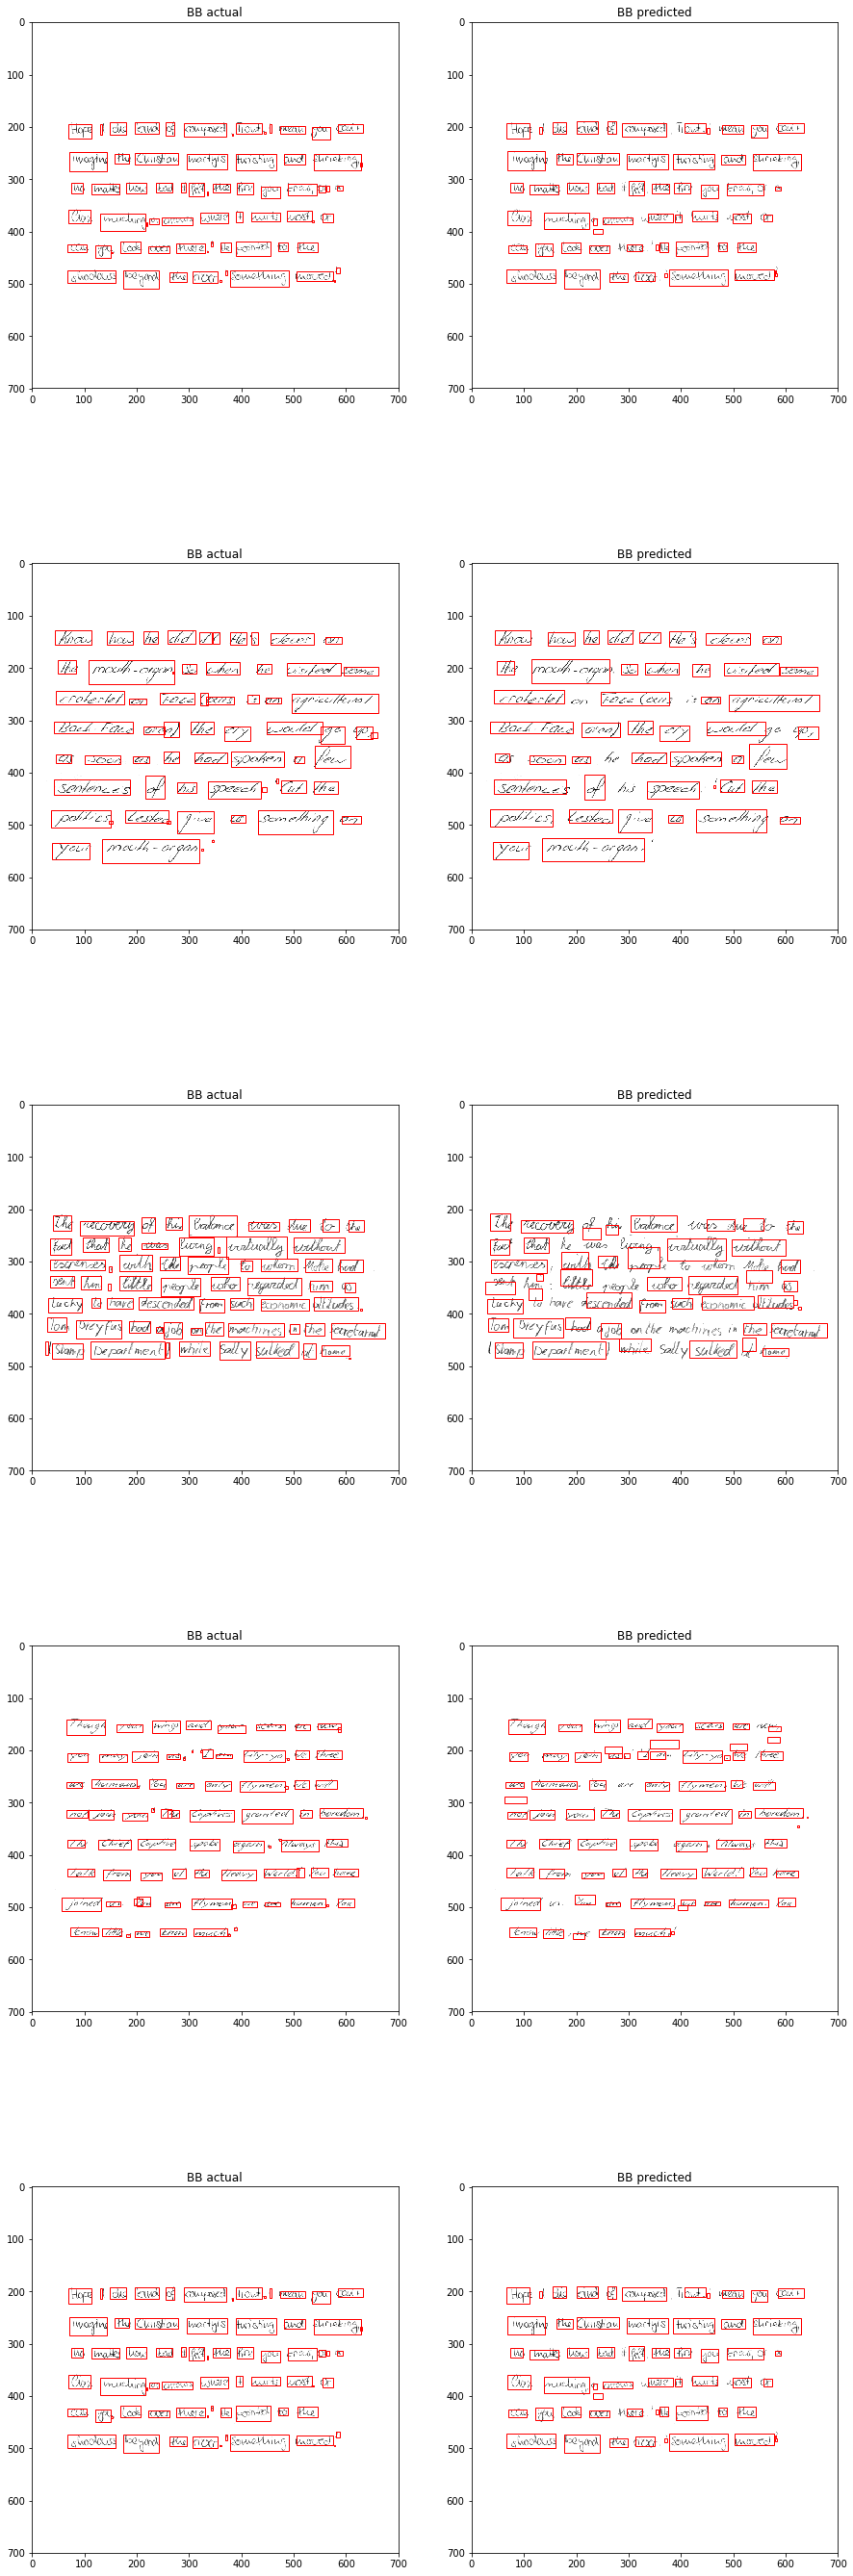

In [20]:
figs_to_plot = 5
fig, axs = plt.subplots(figs_to_plot, 2, figsize=(15, 10 * figs_to_plot))
ds = test_ds
for i in range(figs_to_plot):
    n = int(random.random()*len(ds))
    image, bb = ds[n]
    predicted_bb, actual_bb = predict_bounding_boxes(net, image, bb)
    
    for j in range(actual_bb.shape[0]):
        (x, y, w, h) = actual_bb[j]
        axs[i][0].imshow(image, cmap='Greys_r')
        image_h, image_w = image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[i][0].add_patch(rect)
        axs[i][0].set_title("BB actual")

    for j in range(predicted_bb.shape[0]):
        axs[i][1].imshow(image, cmap='Greys_r')
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[i][1].add_patch(rect)
        axs[i][1].set_title("BB predicted")
